<a href="https://colab.research.google.com/github/Pumafi/flumy-wgan-mines/blob/main/conditioning_mixture_2d_variation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check if a GPU is usable (HIGHLY RECOMMENDED TO TRAIN WITH A GPU)

In [ ]:
!nvidia-smi

Fri Jun 30 16:11:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [ ]:
# From the git
import sys
sys.path.append('..')

from utils.visualisation import *
from utils.utils import generate_noise
from data.load_data import get_3d_flumy_data, load_data, ConditionalDataGenerator
from models.load_trained_models import load_msnwgen_2d_gs_horizontal
from utils.utils import generate_noise, correct_percentage
from matplotlib import colors


In [ ]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Conditioning utilities
from scipy.stats import kde
from keras.utils.np_utils import to_categorical
from sklearn.metrics.pairwise import euclidean_distances

tf.config.run_functions_eagerly(True)

In [ ]:
# Addtional tf options (WARNING: WILL THIS LIBRARY WILL BE ABANDONED)
# We add this line in case the user uses Google Colab
# This is not needed if you are on a local machine and installed the requirements.txt
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

### Workflow

![Image of the conditioning workflow](../images/workflow.png)

**The workflow work as following:**

1. Train/Load a deep learning generator, which weights are then frozen (we suppose the simulations it generates are good) 
2. Create/Load some conditioning data (see this notebook Section "Flumy or Generator Conditional 2D data Generator")
4. Create an Inference Model (Gaussian Mixture or Neural Network)
5. Train inference model

### Useful Variables

In [ ]:
# Data sizes specifications
# Flumy data sizes and latent space sizes
# Change to your data and model specification
# Here images are 64x128 with 4 different geological facies
slice_size = (64, 128, 4)
noise_shape = (8, 16, 1)

## Loading the pretrained Generator Model

In [ ]:
# LOADING MODEL
g_model = load_msnwgen_2d_gs_horizontal(checkpoint_file="../trainedweights/msnwgen2d_gs/cp-msnwgen_maxsort_horizontal_good.ckpt")
g_model.build([None, *noise_shape])
g_model.summary()

Model: "msnwgs_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_initial (Generato  multiple                 40        
 rInitial)                                                       
                                                                 
 generator_block (GeneratorB  multiple                 39556     
 lock)                                                           
                                                                 
 generator_block_1 (Generato  multiple                 27844     
 rBlock)                                                         
                                                                 
 generator_block_2 (Generato  multiple                 7012      
 rBlock)                                                         
                                                                 
 last_generator_block (LastG  multiple            

## Conditioning Data

### Flumy or Generator Conditional 2D data Generator

**We create the conditional data, which returns 3 matrix:**

**x** := the matrix of the same size of the data, with conditioning value (pixel value) where there is conditioning data, 0 otherwise

**msk** := the mask with 1 where there is conditioning data, 0 otherwise

**y** := the real image

In [ ]:
# Create the conditional data (in 2D its pixels with known values, can be adapted to other types of data)

# Whether to test with "real" Flumy data, or with data from generator (used for sanity checks)
flumy_test = True

# How many conditioning wells
nb_wells = 8

if flumy_test:
    # Use conditional data from flumy
    x_train = load_data(slice_size[0], slice_size[1], "../data/horizontal/dataFlumyHoriz.csv")
    dataloader = ConditionalDataGenerator(x_train, 1, slice_size, wells=nb_wells, mode=0)
    x, msk, y = dataloader.__getitem__(0)
else:
    # Use conditional data from our generator
    # We generate a LOT of data to be able to do reject-sampling tests comparison (see below)
    #####################################################
    #                                                   #
    # /!\ WARNING, 7500 may crash if not enough RAM /!\ #
    #                                                   #
    #####################################################
    nb_simulations = 7500
    z_noise = tf.random.normal(shape=(nb_simulations, *noise_shape)) 
    x_train = g_model(z_noise)[-1].numpy()
    x_train =  np.argmax(x_train, axis=-1)
    x_train = tf.keras.utils.to_categorical(x_train)
    dataloader = ConditionalDataGenerator(x_train, 1, slice_size, wells=nb_wells, mode=0)
    x, msk, y = dataloader.__getitem__(0)
    
print(x.shape, msk.shape, y.shape)

(1, 64, 128, 4) (1, 64, 128, 1) (1, 64, 128, 4)


## Models and training

### Gaussian Mixture Conditioning

In [ ]:
from models.conditional_generation.gaussian_mixture import Mixture, train_inference_network

In [ ]:
# How many Gaussian components we want in our Mixture
npart = 10

In [ ]:
# /!\ Seed fixed for test, remove if needed
tf.random.set_seed(222)
gaussian_mixture_model = Mixture(npart = npart)
epochs=15000
history = {"Total Loss": [], "Negative Entropy": [], "Cross Loss": []}
optimiser = train_inference_network(gaussian_mixture_model, g_model, x, msk, history,
                                    epochs=epochs, batch_size=350,lr =0.0005)



  0%|          | 0/15000 [00:00<?, ?it/s]

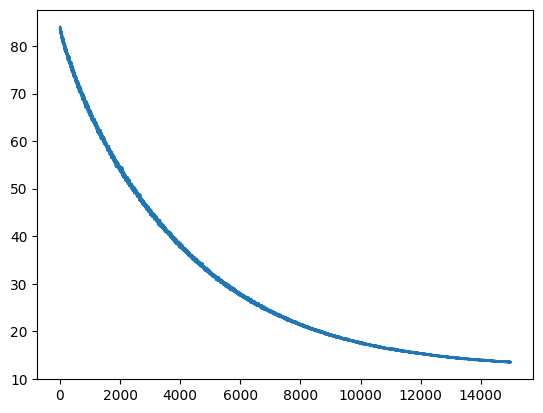

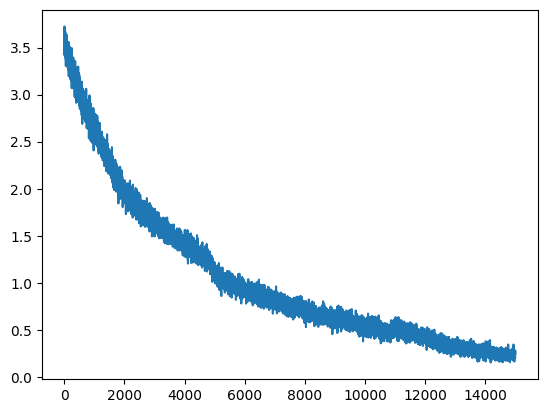

In [ ]:
x_axis = np.arange(len(history["Total Loss"]))
plt.plot(x_axis, history["Total Loss"])
plt.show()
x_axis = np.arange(len(history["Cross Loss"]))
plt.plot(x_axis, history["Cross Loss"])
plt.show()

In [ ]:
# Plot the percentage of success on 100 simulations
z_original = tf.random.normal(shape=(100, *noise_shape))
z, _, _ = gaussian_mixture_model(z_original)

generated_images = g_model(z)[-1]
correct_percentage(generated_images, y, msk, print_res=True)

Percentage of successful predictions 98.38%:


98.375

In [ ]:
from utils.visualisation_conditioning import *
from utils.utils import correct_percentage_histo

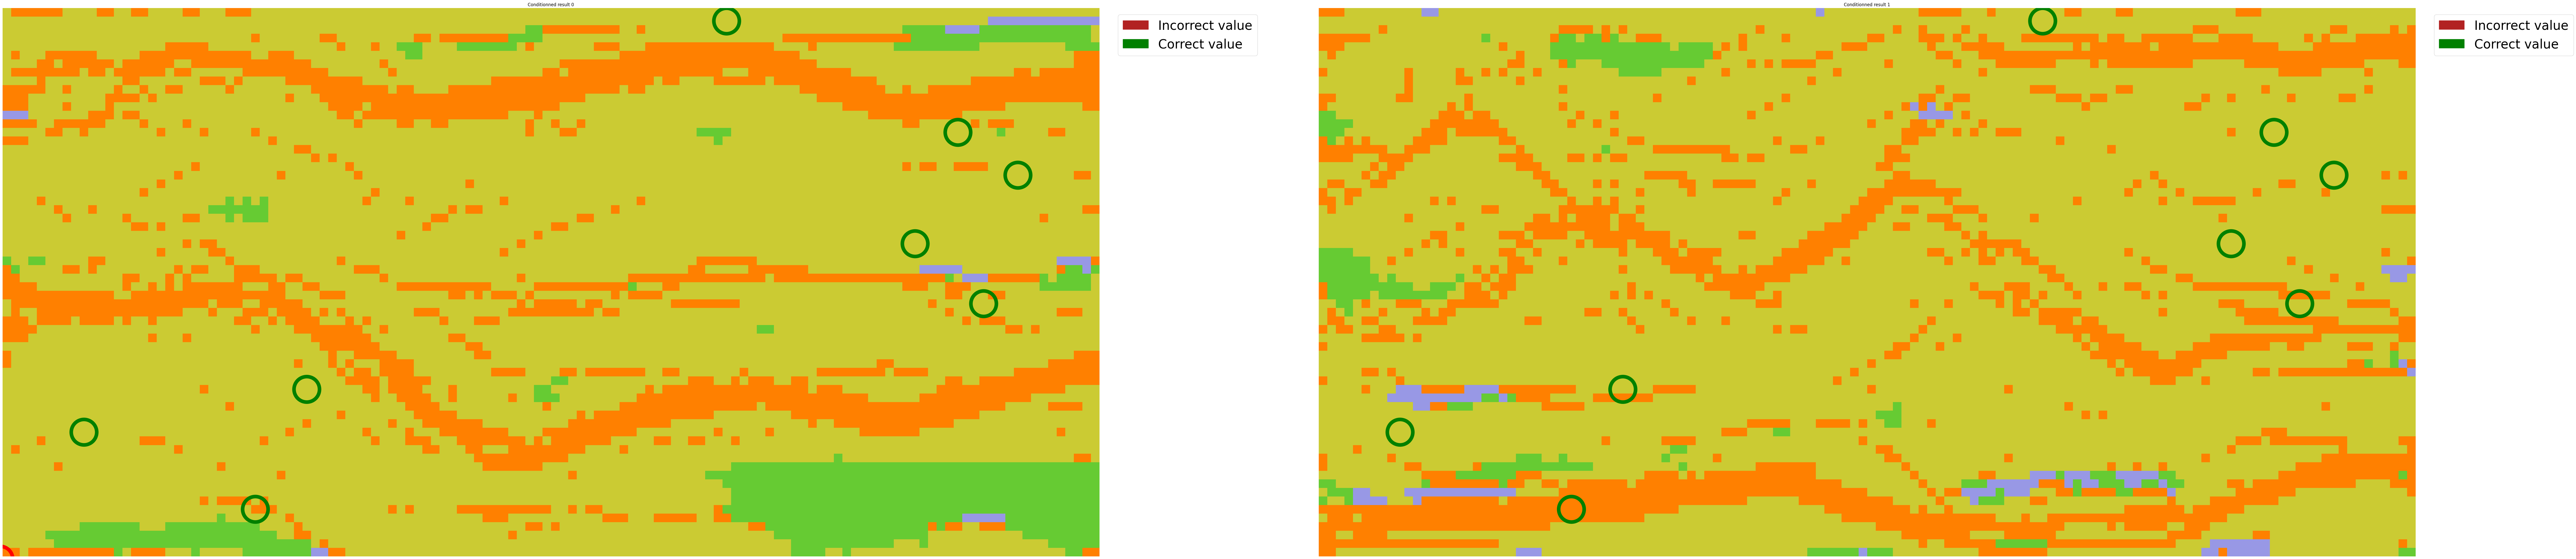

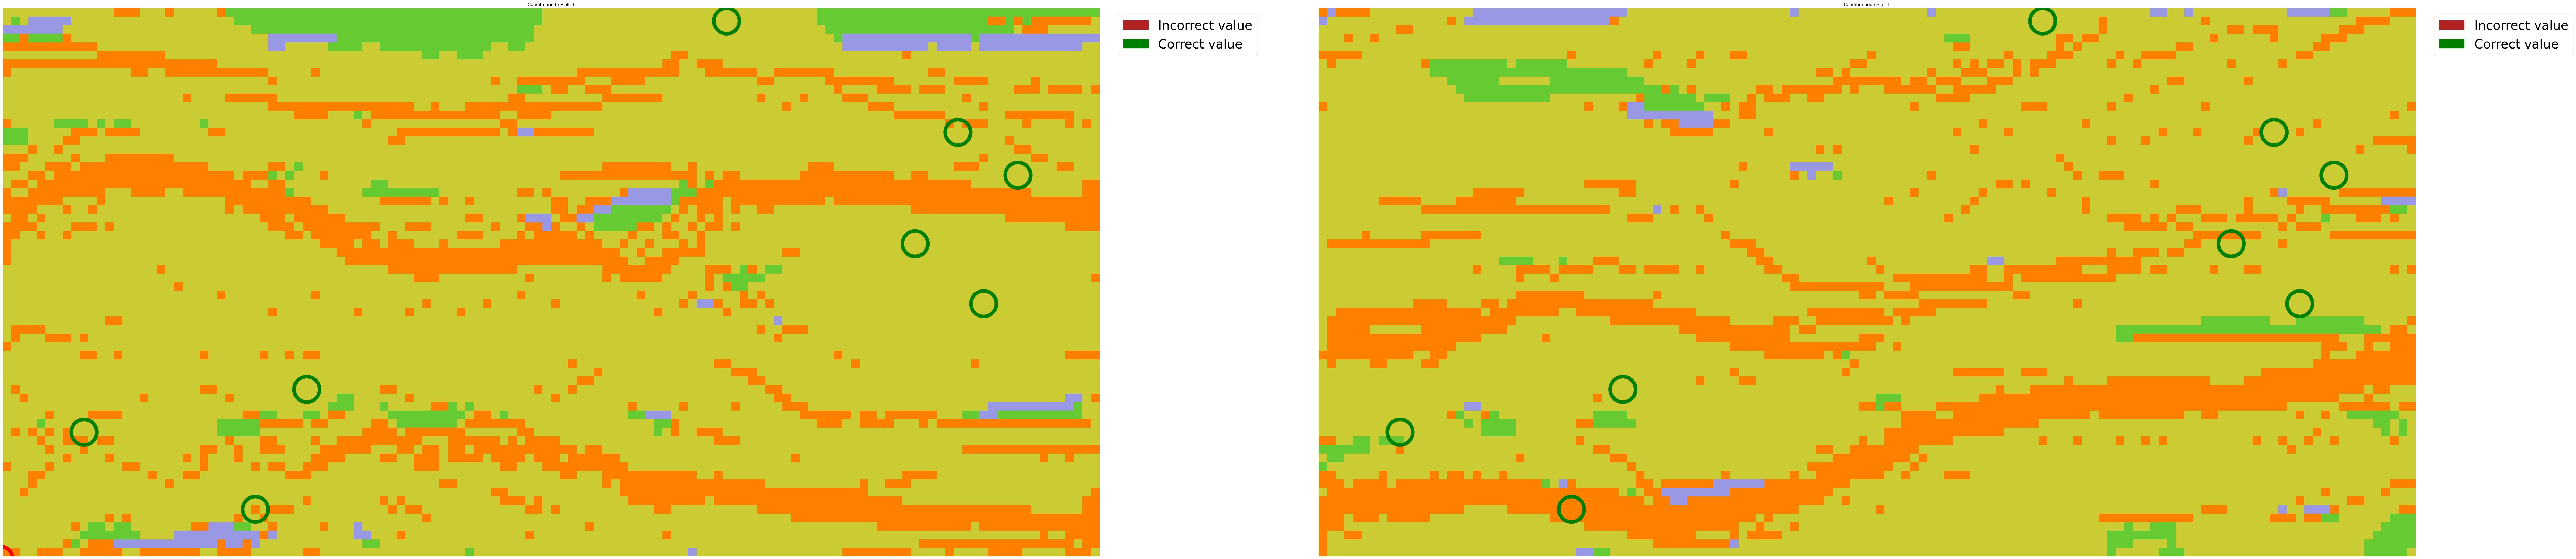

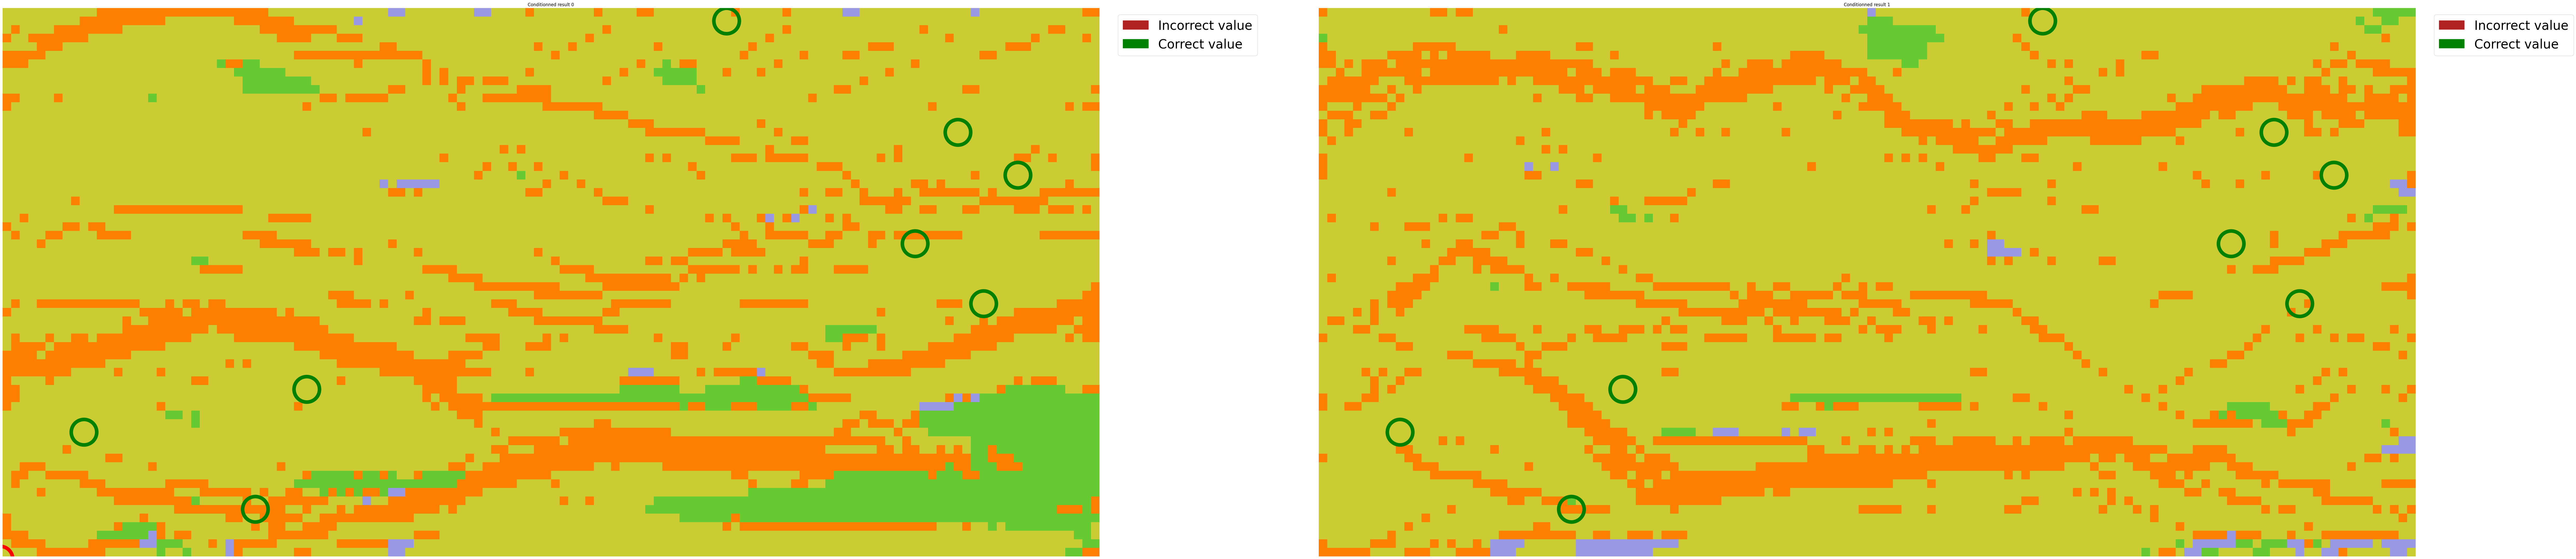

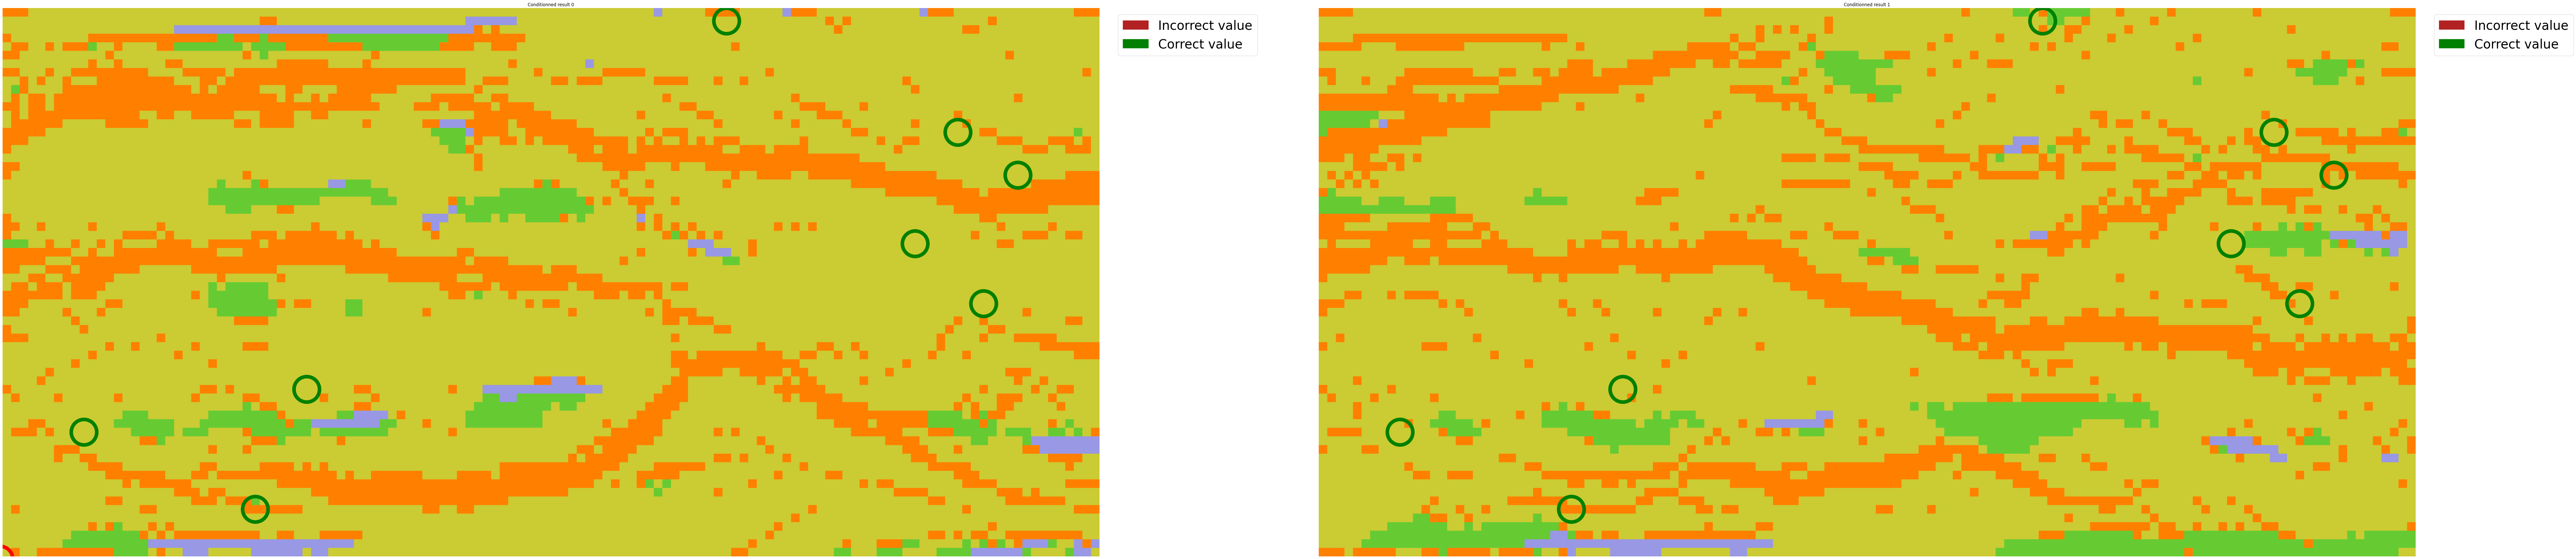

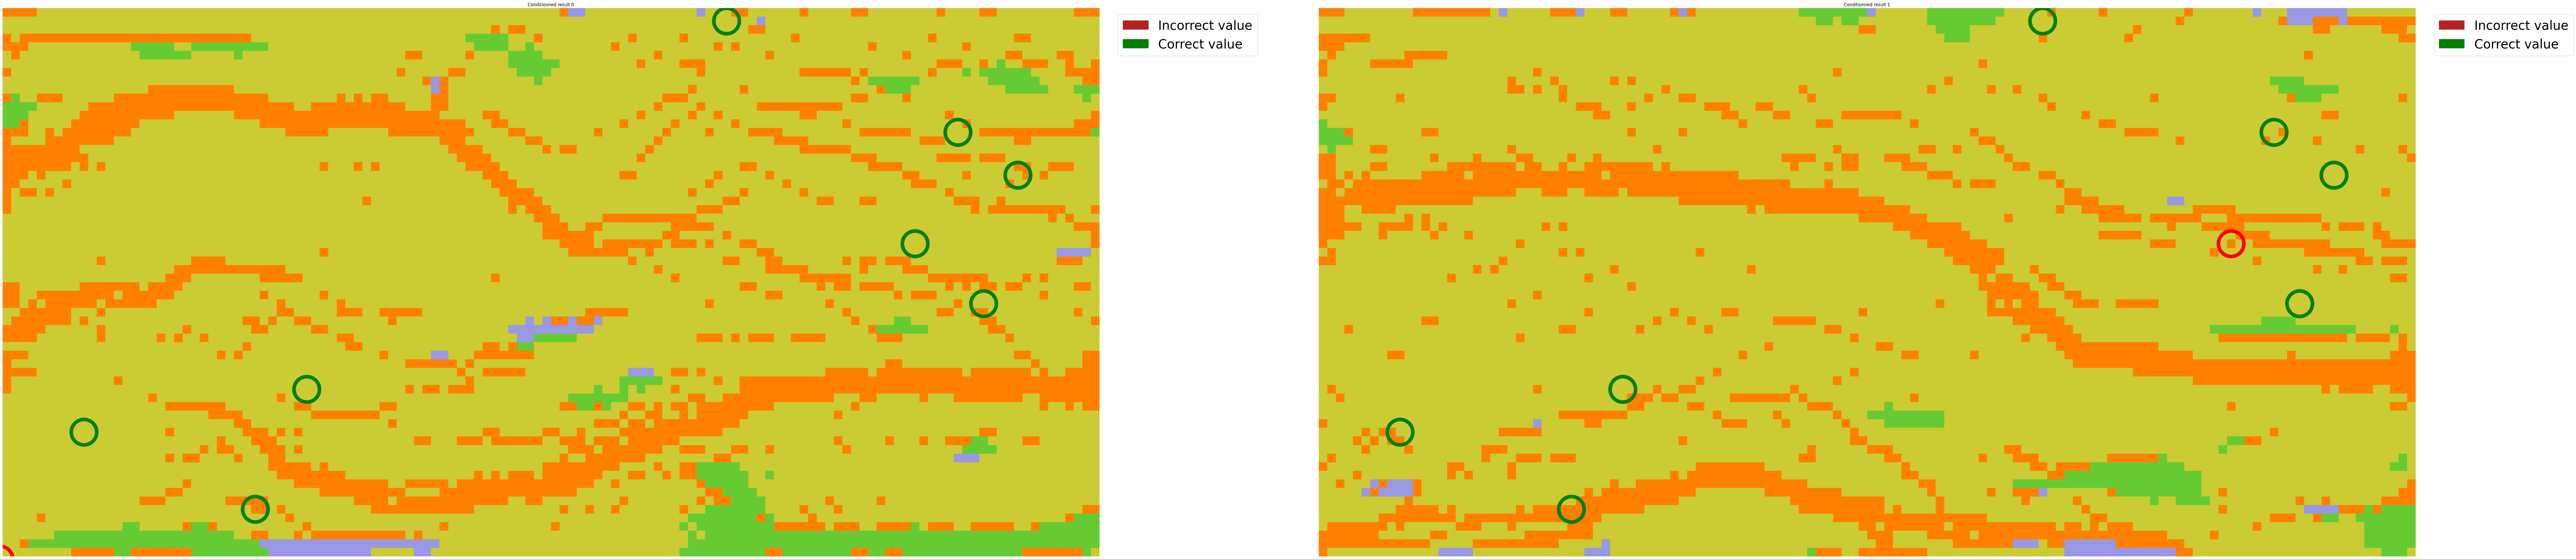

In [ ]:
nb_simulations = 2
cmap, norm = get_color_map(number_of_categories=4)

for i in range(5):
  z_original = tf.random.normal(shape=(nb_simulations, *noise_shape))
  z, _, _ = gaussian_mixture_model(z_original)
  generated_images = g_model(z)[-1]
  print_conditioned_results(x, generated_images, msk, nb_simulations, cmap, norm)


In [ ]:
# Compute probabilities
z_original = tf.random.normal(shape=(2500, 8, 16, 1))
z, _, _ = gaussian_mixture_model(z_original)
generated_images = g_model(z)[-1]

proba_map, most_probable_facies = compute_probability_map(generated_images)
real_proba_map, real_most_probable_facies = compute_probability_map(y)

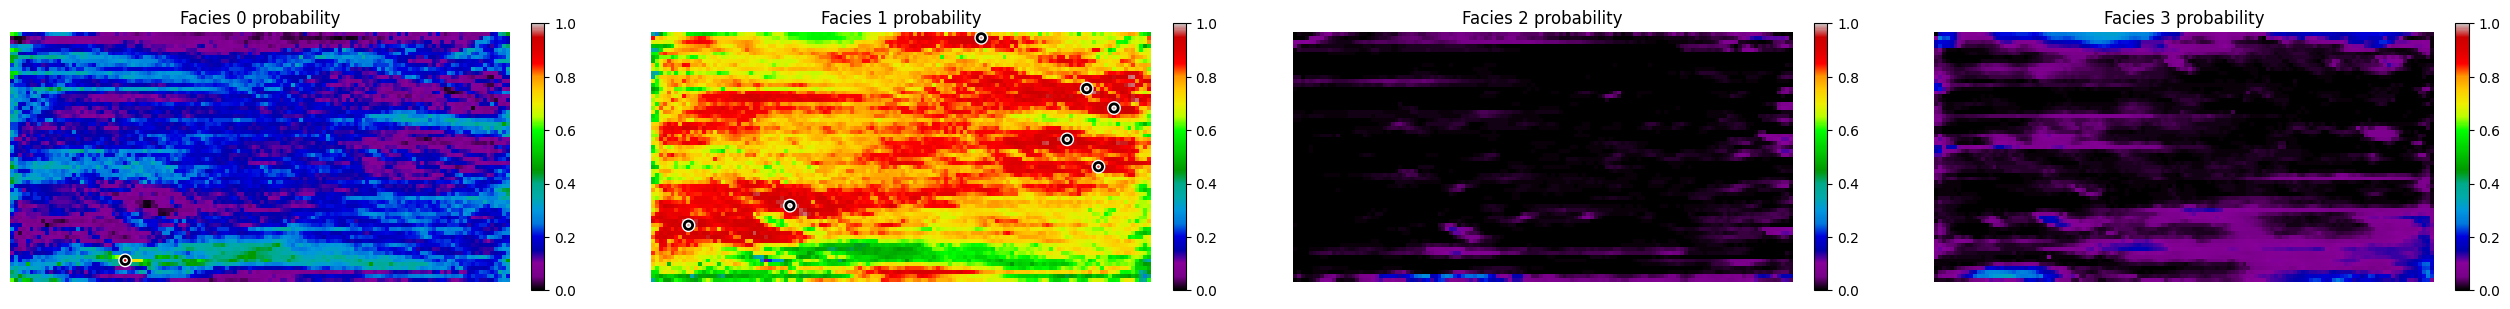

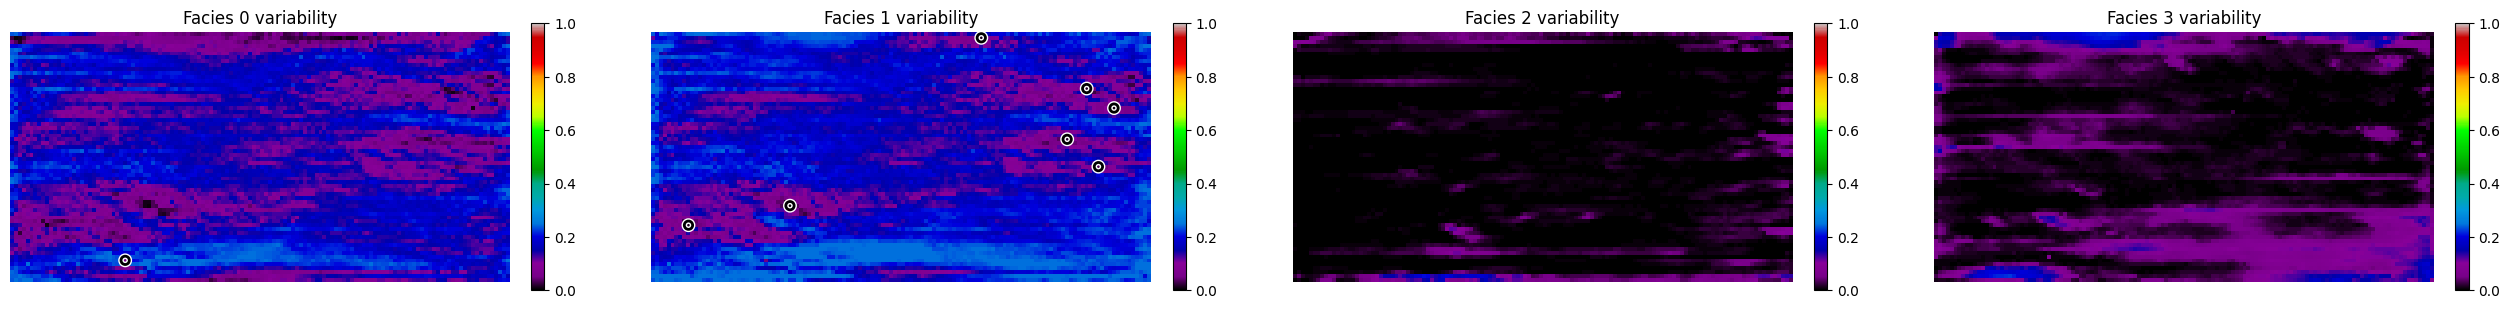

In [ ]:
print_proba_map(proba_map, cmap, norm, samples=x)
print_proba_map(proba_map, cmap, norm, samples=x, plot_variance=True)

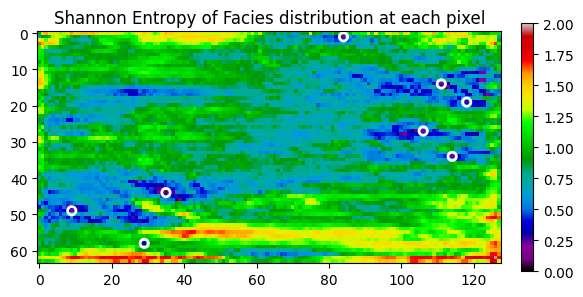

In [ ]:
plot_shannon_entropy_matrix(generated_images, x)

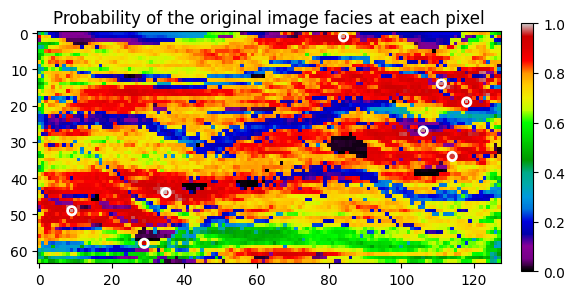

In [ ]:
real_facies_proba(generated_images, y, x)

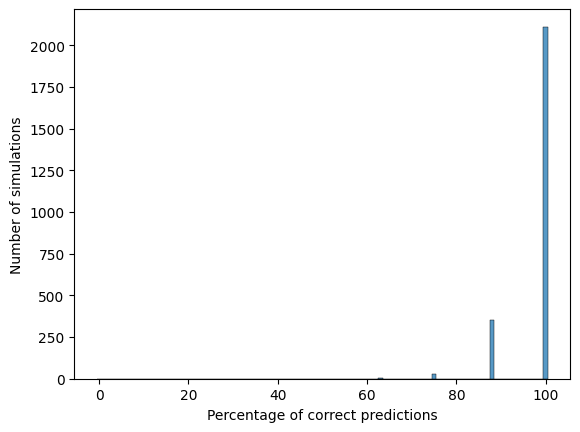

In [ ]:
correct_percentage_histo(generated_images, y, msk, print_res=True)

### Neural Network Inference Model (vanilla model)

In [ ]:
from models.conditional_generation.conditional_losses import kozachenko_entropy_estimation, loss_function_crossentropy_2d
from models.conditional_generation.parametric_generation_network import InferenceModel, train_inference_network

In [ ]:
input_shape_vanilla = (8, 16, 1)

In [ ]:
inference_network_vanilla = InferenceModel(noise_shape)
epochs=7500
history_vanilla = train_inference_network(inference_network_vanilla, g_model, x, msk, input_shape_vanilla, epochs=epochs, batch_size=150)

  0%|          | 0/7500 [00:00<?, ?it/s]

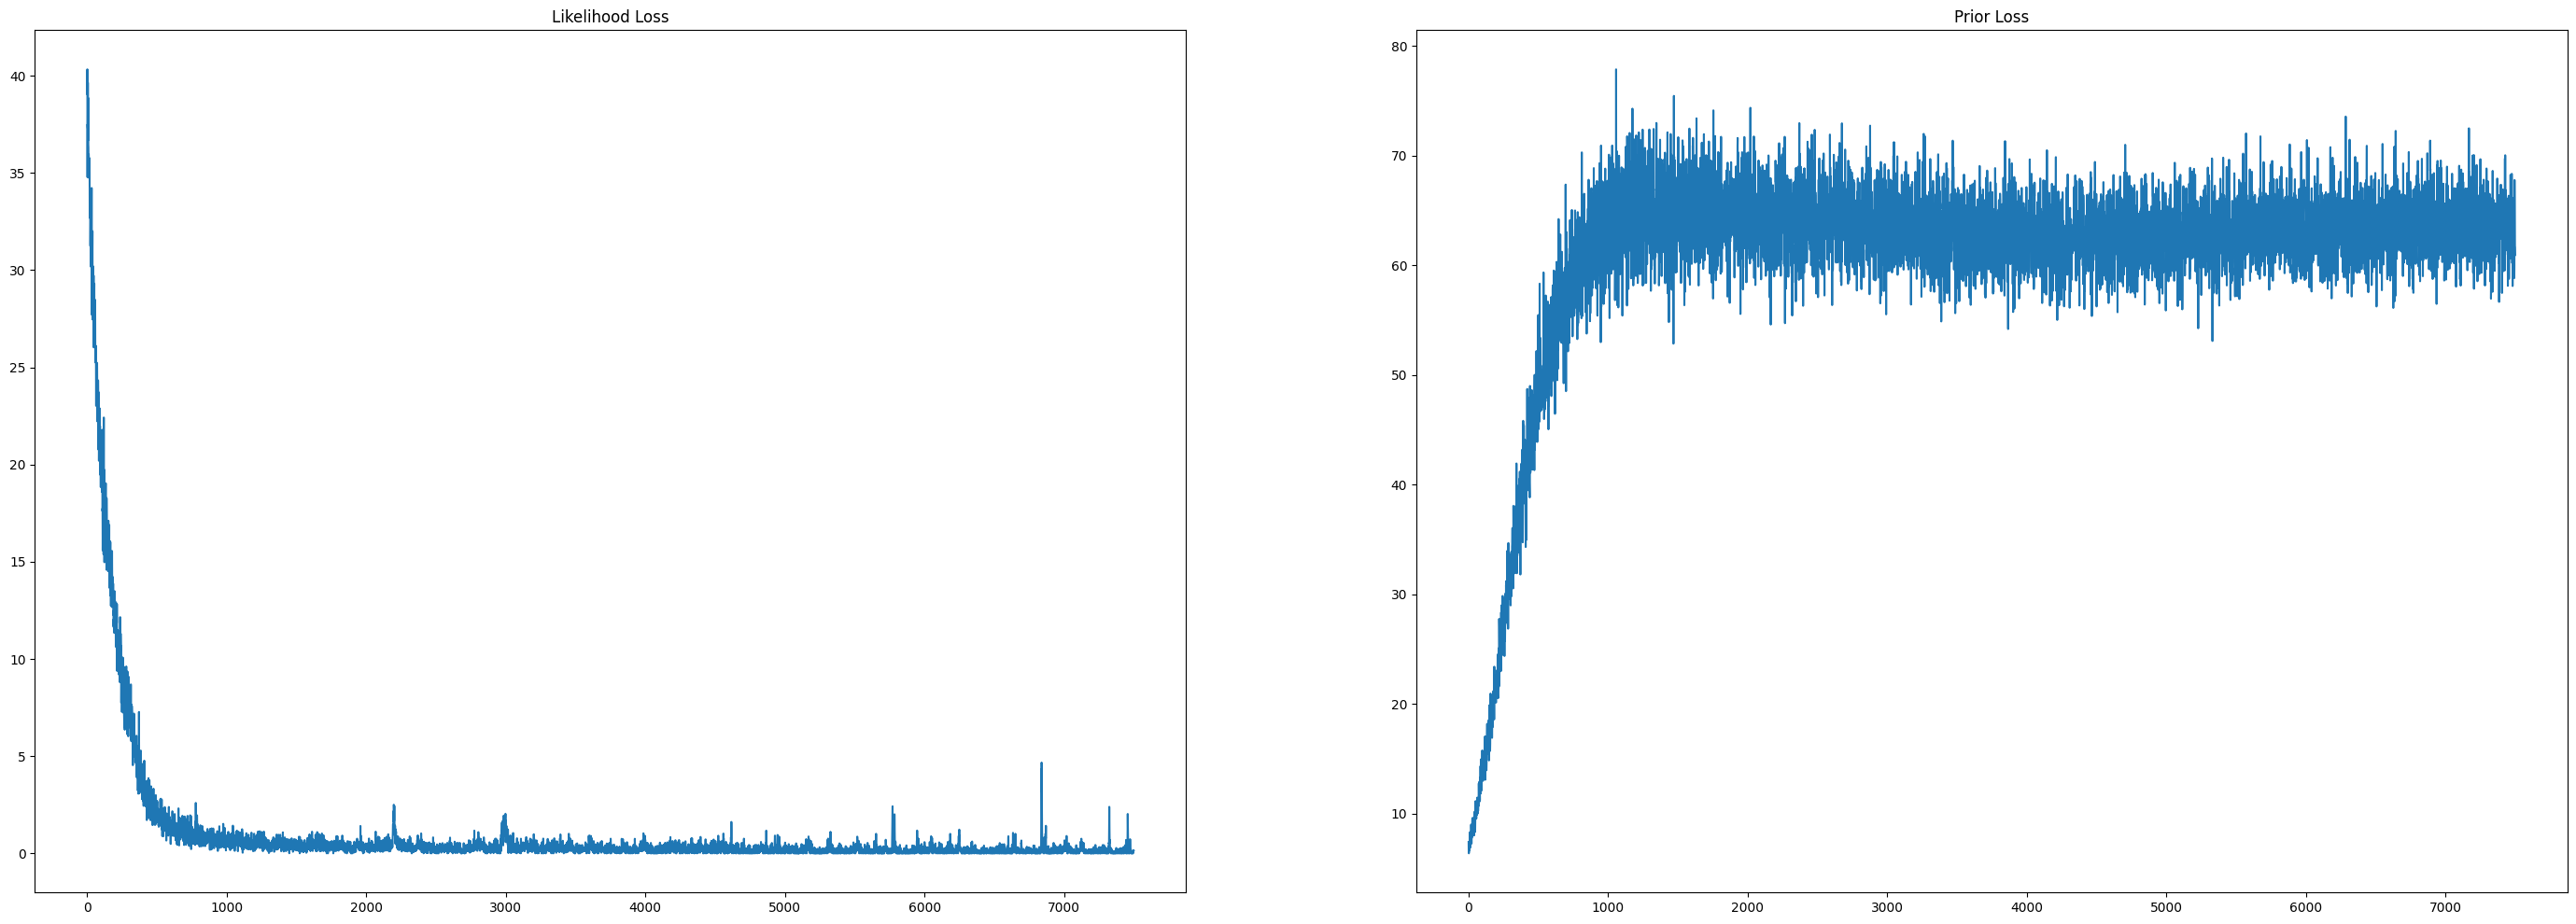

In [ ]:
x_axis = np.arange(epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 2, 1)
plt.title("Likelihood Loss")
plt.plot(x_axis, history_vanilla["Likelihood Loss"])
plt.subplot(1, 2, 2)
plt.title("Prior Loss")
plt.plot(x_axis, history_vanilla["Prior Loss"])

In [ ]:
z_original_vanilla = tf.random.normal(shape=(2500, *input_shape_vanilla))
z = inference_network_vanilla(z_original_vanilla)
generated_images_vanilla = g_model(z)[-1]
correct_percentage(generated_images_vanilla, y, msk, print_res=True)

Percentage of successful predictions 99.90%:


99.9

In [ ]:
proba_map_vanilla, most_probable_facies_vanilla = compute_probability_map(generated_images_vanilla)

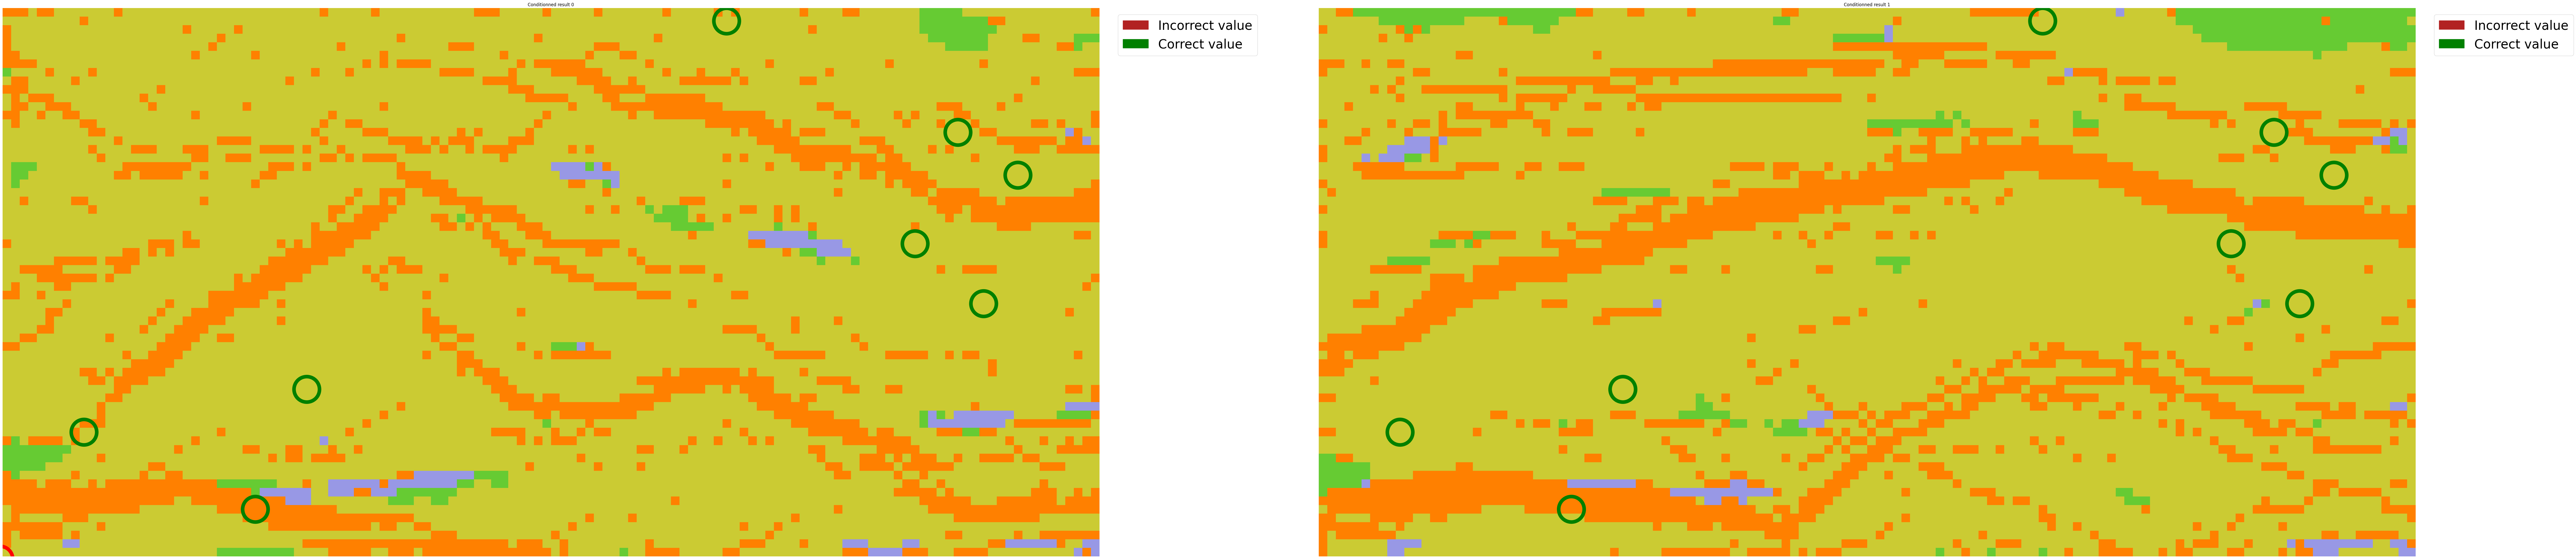

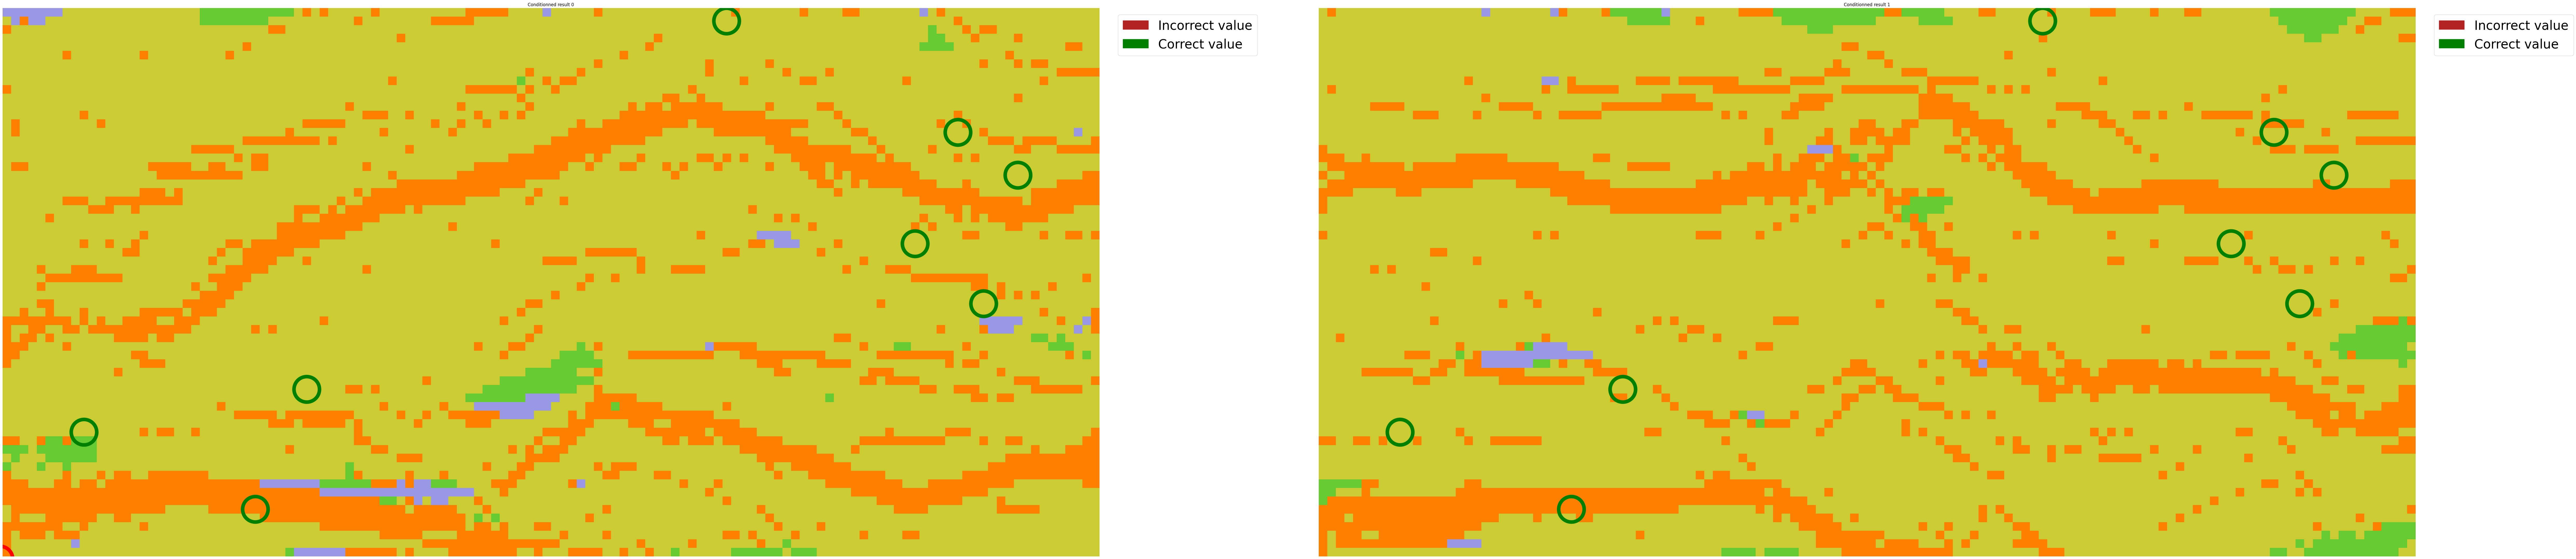

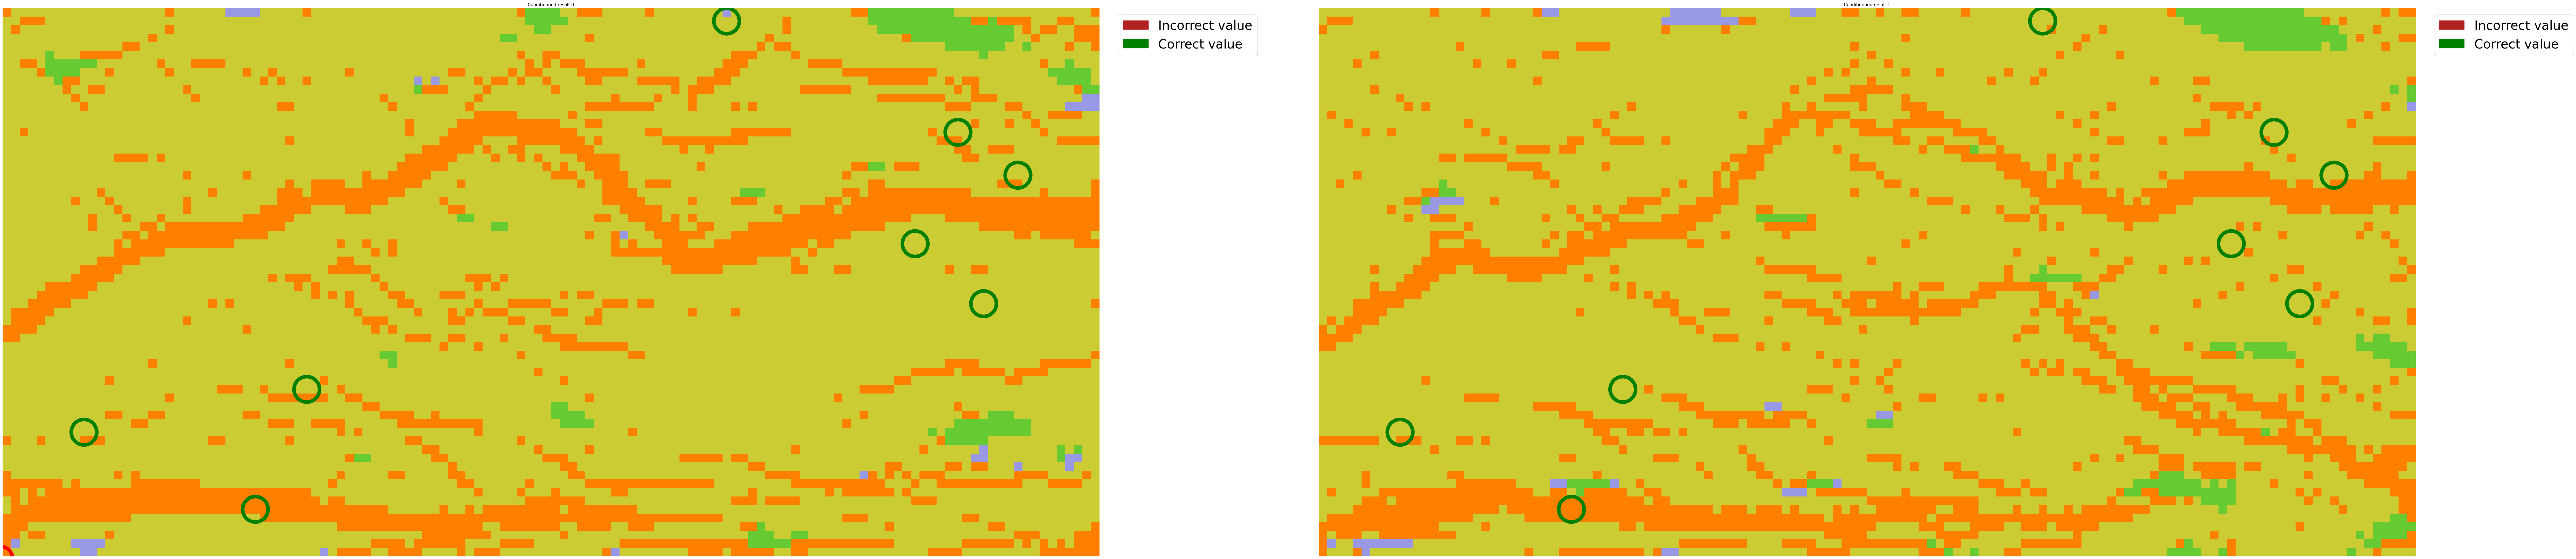

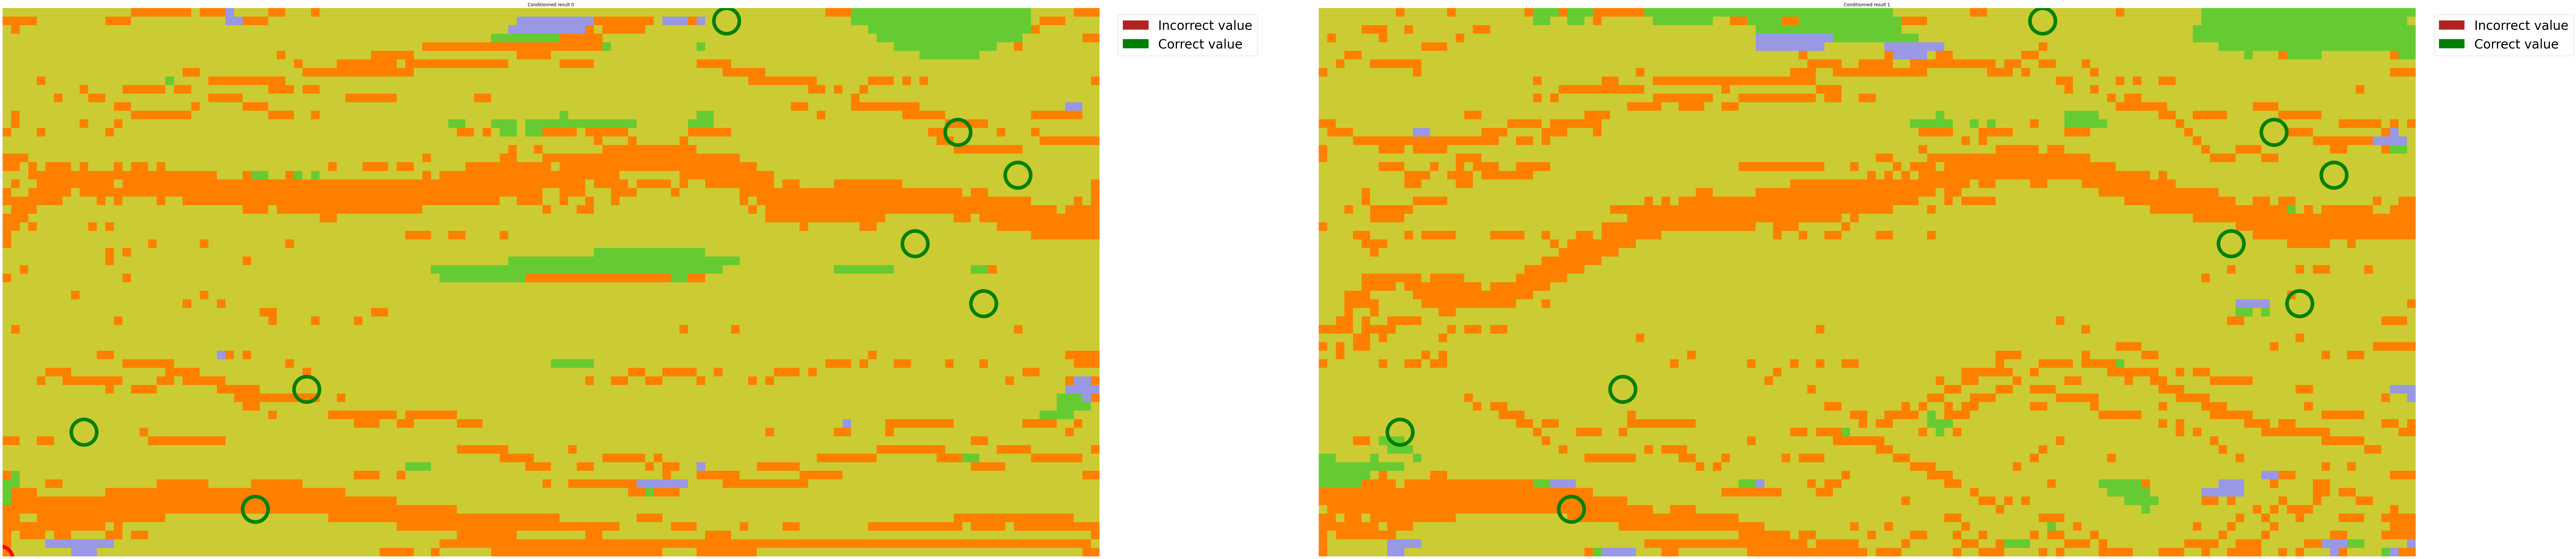

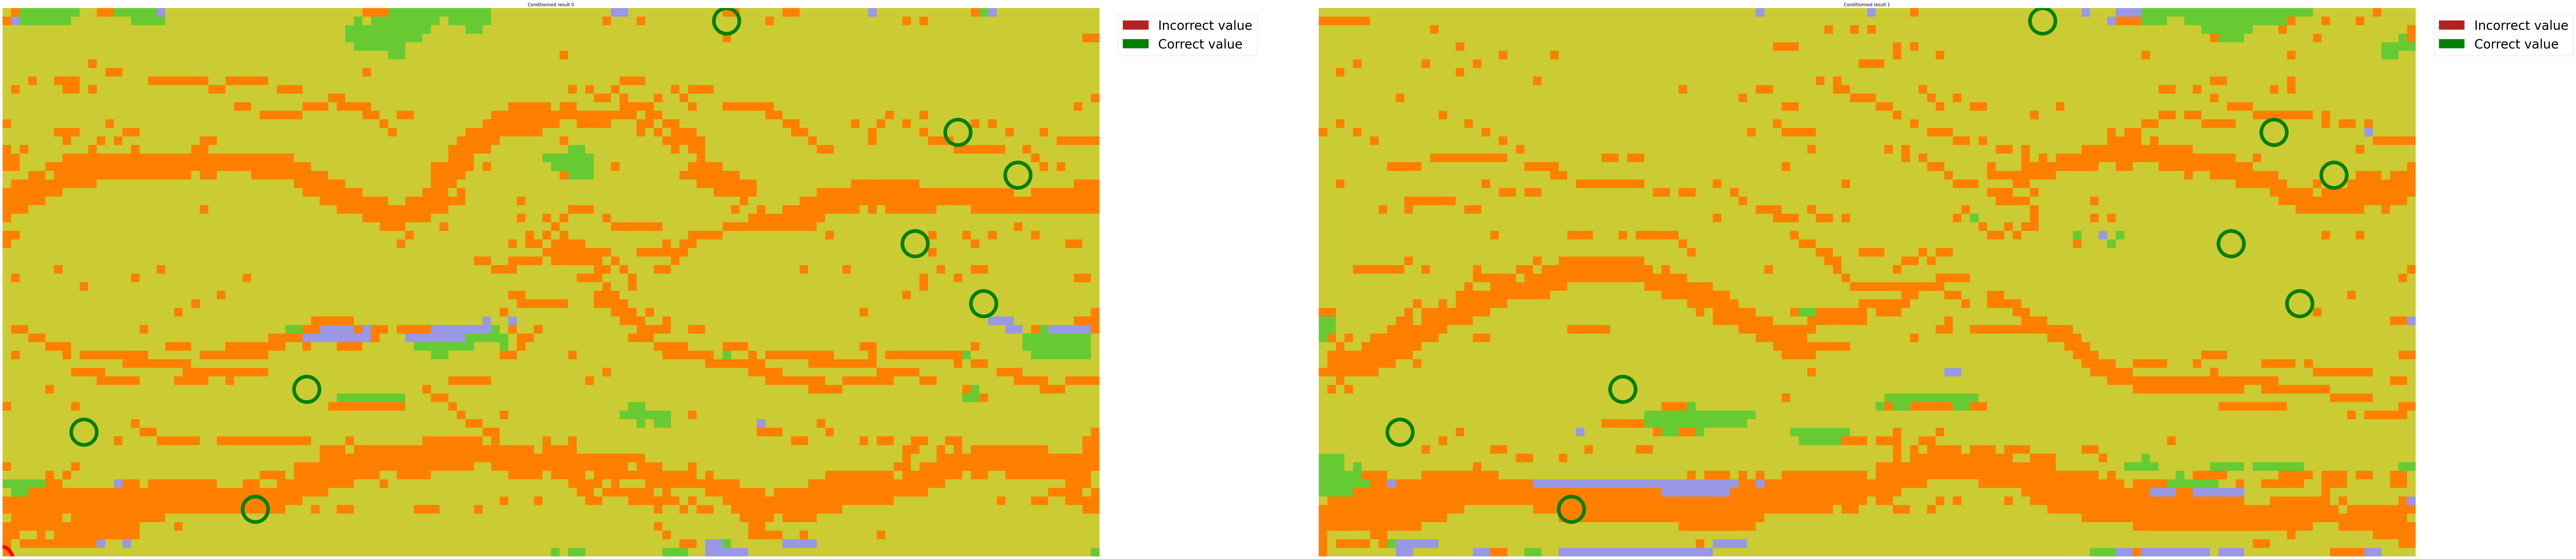

In [ ]:
nb_simulations = 2
cmap, norm = get_color_map(number_of_categories=4)

for i in range(5):
  z_original = tf.random.normal(shape=(nb_simulations, *input_shape_vanilla))
  z = inference_network_vanilla(z_original)
  generated_images = g_model(z)[-1]
  print_conditioned_results(x, generated_images, msk, nb_simulations, cmap, norm)

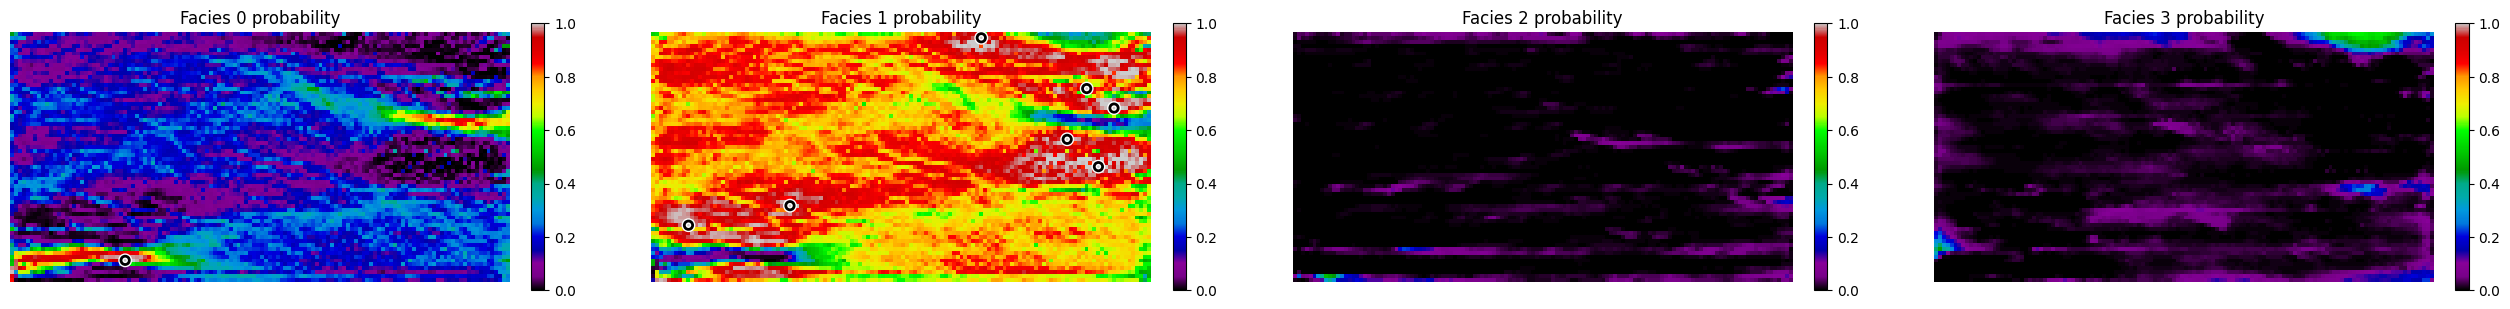

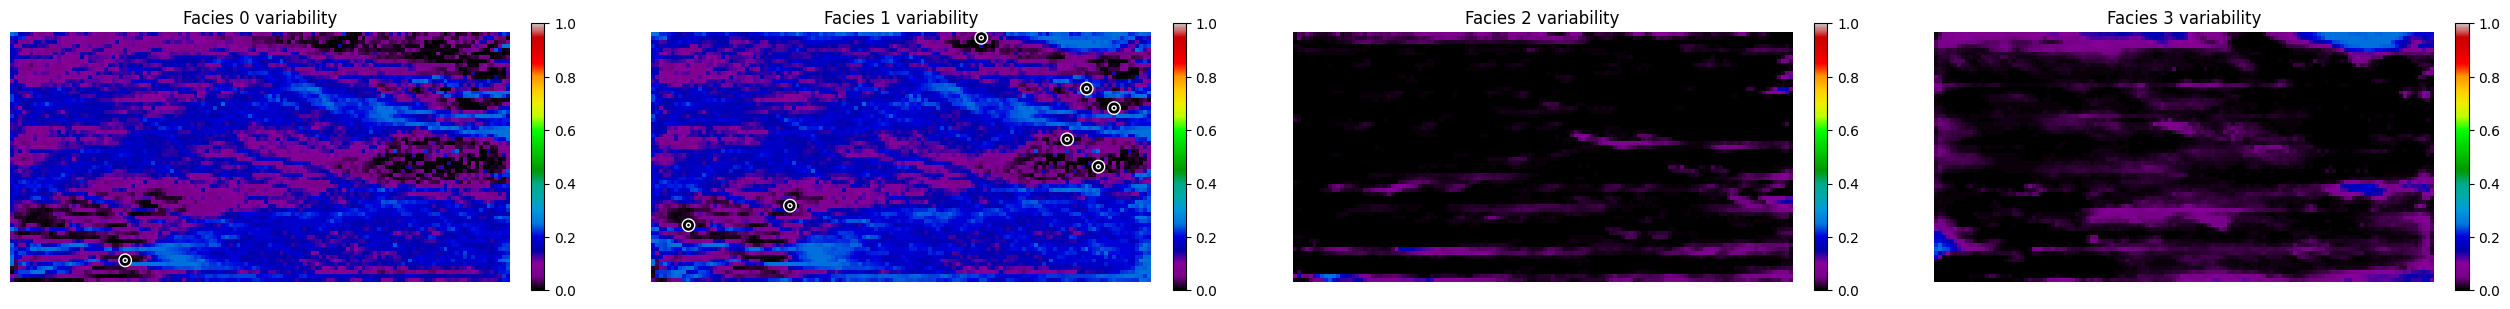

In [ ]:
print_proba_map(proba_map_vanilla, cmap, norm, samples=x)
print_proba_map(proba_map_vanilla, cmap, norm, samples=x, plot_variance=True)

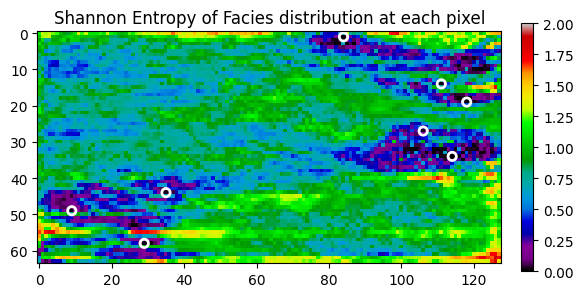

In [ ]:
plot_shannon_entropy_matrix(proba_map_vanilla, x)

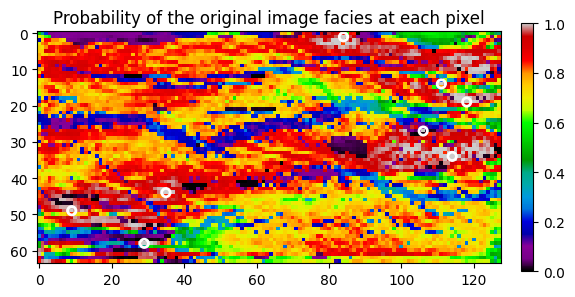

In [ ]:
real_facies_proba(proba_map_vanilla, y, x)

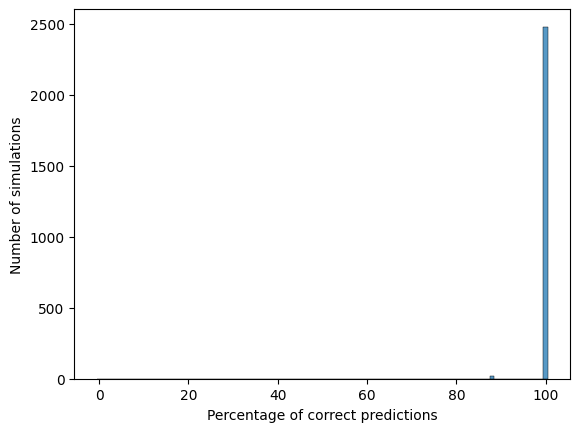

In [ ]:
correct_percentage_histo(generated_images_vanilla, y, msk, print_res=True)

## Rejection Sampling

In this section, we use Rejection Sampling (https://en.wikipedia.org/wiki/Rejection_sampling) to compare the variability of both previous method to what types of simulations can actually be expected.

We simply sample a LOT of data, and keep only those that fit our observations (lot of data is needed, and the more conditioning points there are, the more complicated it is to actually sample enough to do a comparison).

In [ ]:
# Get our conditioning points coordinates
_, x_cond_pxl, y_cond_pxl, _ = np.nonzero(msk)

In [ ]:
# finding all simulations that corresponds (accept-reject sampling style)
filter = np.squeeze(np.all(np.reshape((x_train[:, x_cond_pxl, y_cond_pxl] == np.squeeze(x[:, x_cond_pxl, y_cond_pxl])), (-1, 8 * 4)), axis=-1))
valid_true_cond_sims = x_train[filter]

In [ ]:
valid_true_cond_sims.shape

(282, 64, 128, 4)

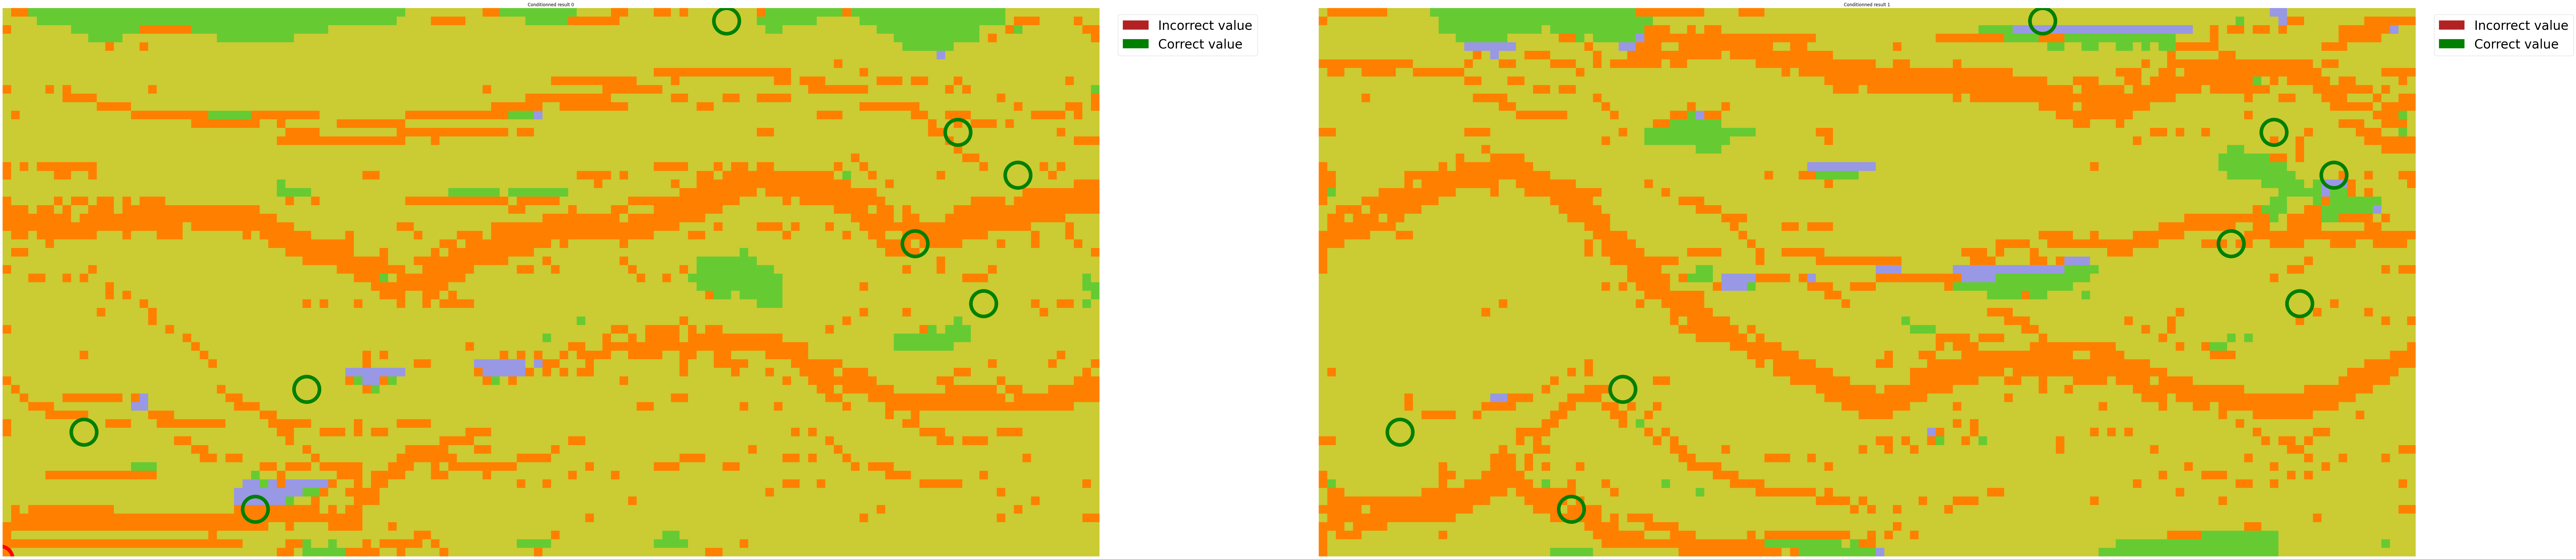

In [ ]:

nb_simulations = 2
cmap, norm = get_color_map(number_of_categories=4)

for i in range(1):
  print_conditioned_results(x, valid_true_cond_sims, msk, nb_simulations, cmap, norm)

In [ ]:
valid_true_cond_proba_map, _ = compute_probability_map(valid_true_cond_sims)

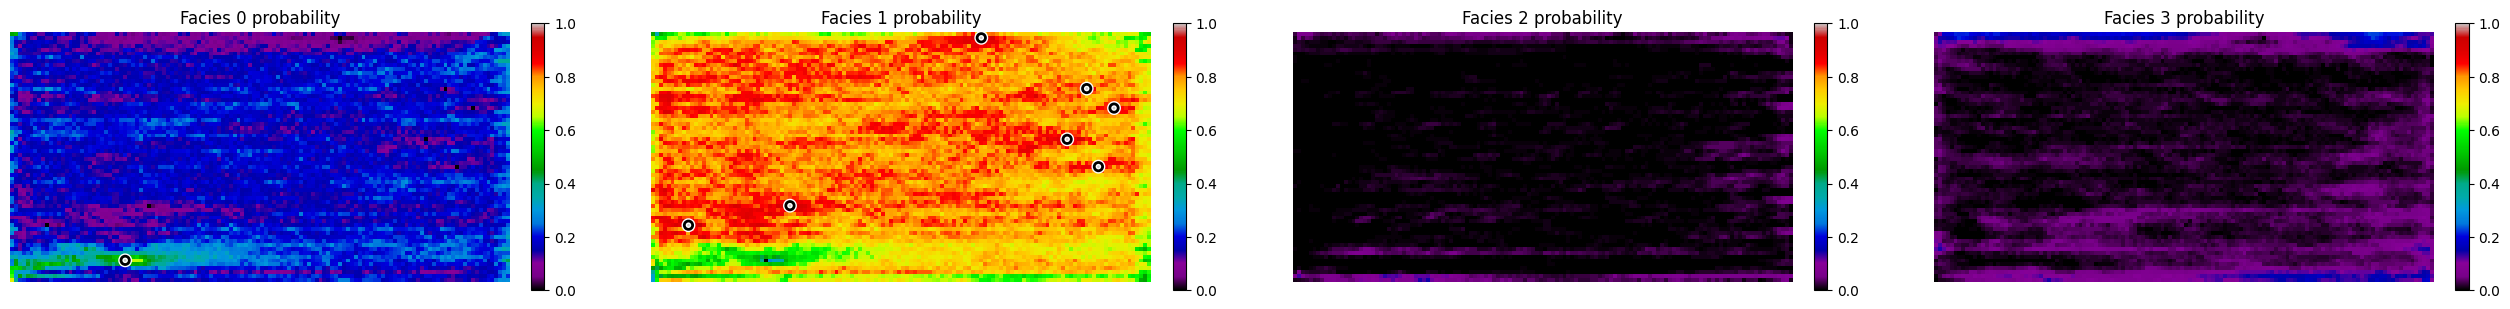

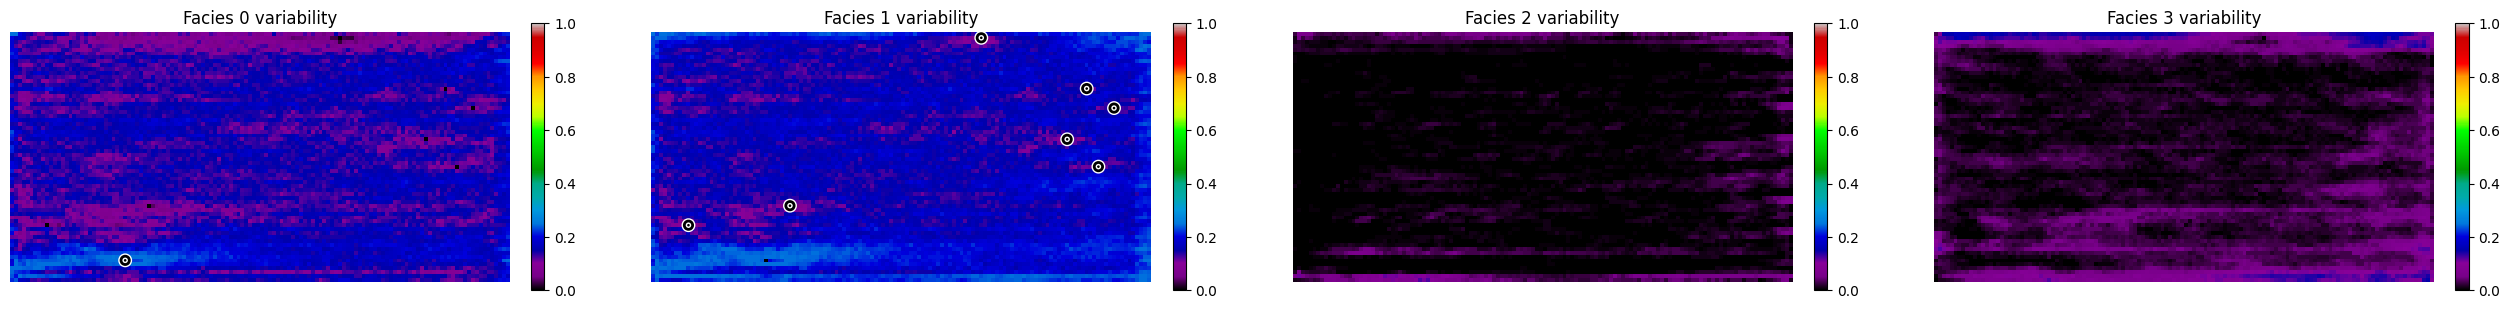

In [ ]:
print_proba_map(valid_true_cond_proba_map, cmap, norm, samples=x)
print_proba_map(valid_true_cond_proba_map, cmap, norm, samples=x, plot_variance=True)